In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from hmmlearn import hmm
import math
from hmmlearn.base import ConvergenceMonitor

In [4]:
class ThresholdMonitor(ConvergenceMonitor):
    @property
    def converged(self):
        return (self.iter == self.n_iter or self.history[-1] >= self.tol)

# Familiarizing with the data

In [158]:
data = pd.read_csv('Google.csv')

In [159]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,2004-08-20,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,2004-08-23,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,2004-08-24,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,2004-08-25,52.140873,53.651051,51.604362,52.657513,52.657513,9257400


In [160]:
close = data['Close']

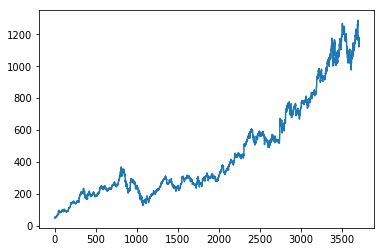

In [161]:
plt.plot(close)

# Data Cleaning

In [166]:
### Return train, test ### 

def train_test_split(df, split_r = 0.9):
    total = len(df)
    idx = round(total * 0.8)
    return df[:idx], df[idx:]

Transform the data frame to make each day's value be like:  <br> <br>
$$(\frac{close-open}{open}, \frac{high-open}{open}, \frac{low-open}{open})$$

In [167]:
def transform_data(df):
    for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
        high, low = df.loc[idx, 'High'], df.loc[idx, 'Low']
        open, close = df.loc[idx, 'Open'], df.loc[idx, 'Close']
        df.loc[idx, '%'] = (close - open) / open
        df.loc[idx, '%+'] = (high - open) / open
        df.loc[idx, '%-'] = (low - open) / open

In [168]:
train, test = train_test_split(data)

In [169]:
transform_data(train)
transform_data(test)

In [15]:
train.head()

,Date,Open,High,Low,Close,Volume,%,%+,%-
0,03-01-00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,-0.009549,0.005955,-0.021024
1,04-01-00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,-0.038345,0.000000,-0.039712
2,05-01-00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.001922,0.009897,-0.015535
3,06-01-00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.000956,0.006982,-0.007139
4,07-01-00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.027090,0.027090,-0.001938


In [18]:
# Reorganize the data into numpy array
# Lookback window = 10

def to_numpy(df):
    X = []
    for idx, row in tqdm(df[10:].iterrows(), total=df.shape[0]-10):
        start = idx - 10
        for i in range(start, idx + 1):
            X.append([df.loc[i, "%"], df.loc[i, "%+"], df.loc[i, "%-"]])
    return np.array(X)

In [19]:
X_train = to_numpy(train)
X_test = to_numpy(test)

In [25]:
X_train = train.get(['%','%+','%-']).values
X_test = test.get(['%','%+','%-']).values

# Run K-means

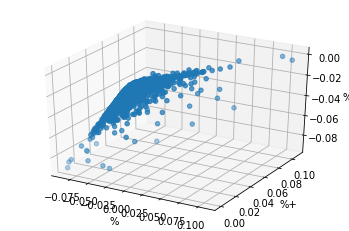

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,[0]], X_train[:,[1]], X_train[:,[2]], marker='o')
ax.set_xlabel('%')
ax.set_ylabel('%+')
ax.set_zlabel('%-')
plt.show()

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

iris = datasets.load_iris()
X = X_train

model = KMeans(n_clusters=5)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
classes = {0:[],1:[],2:[],3:[],4:[]}
for i in range(X.shape[0]):
    idx = model.labels_[i]
    classes[idx].append(X[i])

In [55]:
class0 = np.array(classes[0])
class1 = np.array(classes[1])
class2 = np.array(classes[2])
class3 = np.array(classes[3])
class4 = np.array(classes[4])

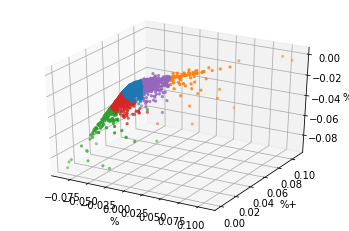

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class0[:,[0]], class0[:,[1]], class0[:,[2]], marker='.')
ax.scatter(class1[:,[0]], class1[:,[1]], class1[:,[2]], marker='.')
ax.scatter(class2[:,[0]], class2[:,[1]], class2[:,[2]], marker='.')
ax.scatter(class3[:,[0]], class3[:,[1]], class3[:,[2]], marker='.')
ax.scatter(class4[:,[0]], class4[:,[1]], class4[:,[2]], marker='.')
ax.set_xlabel('%')
ax.set_ylabel('%+')
ax.set_zlabel('%-')
plt.show()

In [79]:
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Params Initialization

In [37]:
startprob_prior = np.array([0.25, 0.25, 0.25, 0.25])
transmat_prior = np.array([[1/4.0,1/4.0,1/4.0,1/4.0],
                           [1/4.0,1/4.0,1/4.0,1/4.0],
                           [1/4.0,1/4.0,1/4.0,1/4.0],
                           [1/4.0,1/4.0,1/4.0,1/4.0]])

In [32]:
weights_prior = np.array([])
means_weight = np.array([])
covars_weight = np.array([])

0.25

# Fit GMMHMM

In [75]:
gmmhmm = hmm.GMMHMM(n_components=4, n_mix = 5, startprob_prior = startprob_prior, transmat_prior = transmat_prior, n_iter = 100)
gmmhmm.monitor_ = ThresholdMonitor(gmmhmm.monitor_.tol,
                                   gmmhmm.monitor_.n_iter,
                                   gmmhmm.monitor_.verbose)

In [76]:
gmmhmm.fit(X_train)

GMMHMM(algorithm='viterbi', covariance_type='diag',
    covars_prior=array([[[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

   ..., -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]]]),
    covars_weight=array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]),
    init_params='stmcw',
    means_prior=array([[[0., 0., 0.],
        [

In [77]:
gmmhmm.monitor_

ThresholdMonitor(
    history=[26100.734481536805],
    iter=1,
    n_iter=100,
    tol=0.01,
    verbose=False,
)

In [80]:
gmmhmm.get_stationary_distribution()

array([0.18183386, 0.35157747, 0.36075572, 0.10583295])

In [84]:
gmmhmm.predict(X_test)[:20]

array([0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1])

In [150]:
for i in range(X_test.shape[0]):
    if X_test[i][0]>0.025 or X_test[i][0]<-0.025:
        print(i)

175
176
178
182
274
387
793
794
796


In [151]:
i = 171
test1 = X_test[i:10+i]
X_test[i+11]

array([-0.02854691,  0.        , -0.03401876])

In [152]:
max_score = -999999
max_k = None
for i in tqdm(range(100)):
        for j in range(50):
            for k in range(50):
                percent = -0.1 + i * (0.2/100)
                percent_increase = j * (0.1 / 50)
                percent_decrease = -0.1 + k * (0.1 / 50)
                k = np.array([[percent,percent_increase,percent_decrease]])
                x = np.concatenate([test1, k])
                score = gmmhmm.score(x)
                if score>max_score:
                    max_k = k
                    max_score = score

In [157]:
max_k

array([[ 0.   ,  0.006, -0.006]])

In [156]:
gmmhmm.score(np.concatenate([test1, np.array([[-0.02854691,  0.        , -0.03401876]])]))

88.48943728120307

# Predictions

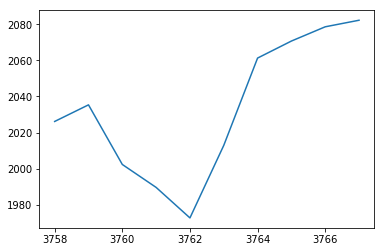

In [137]:
plt.plot(test['Close'][:10])

In [89]:
# Input: 10 * 3 series (%, %+, %-)*10, and last closing value
# Output: Closing Value of the stock price

def predict(x, close_val):
    res_score = {}
    for i in tqdm(range(50)):
        for j in range(10):
            for k in range(10):
                percent = -0.1 + i * (0.2/50)
                percent_increase = j * (0.1 / 10)
                percent_decrease = -0.1 + k * (0.1 / 10)
                
                series = np.concatenate((x, [[percent, percent_increase, percent_decrease]]), axis = 0)
                score = math.exp(gmmhmm.score(series, lengths = [11]))
                if(i == 25 and j == 5 and k == 9): print(score)
                res_score[f'{percent,percent_increase,percent_decrease}'] = score
    print(res_score)
    change_prediction = max(res_score, key=res_score.get).split(', ')
    change_prediction = [float(change_prediction[0][1:]), float(change_prediction[1]), float(change_prediction[2][:-1])]
    return np.array(change_prediction), close_val * (1 + change_prediction[2])

In [90]:
predict(X_train[-20:-10], train.loc[len(train)-1, "Close"])

4.8459571278094386e+48

{'(-0.1, 0.0, -0.1)': 6.27531690984642e+46, '(-0.1, 0.0, -0.09000000000000001)': 8.48836431316582e+46, '(-0.1, 0.0, -0.08)': 1.111533175268891e+47, '(-0.1, 0.0, -0.07)': 1.4109123142480565e+47, '(-0.1, 0.0, -0.060000000000000005)': 1.734156099129615e+47, '(-0.1, 0.0, -0.05)': 2.0560725545702993e+47, '(-0.1, 0.0, -0.04000000000000001)': 2.3366963795107113e+47, '(-0.1, 0.0, -0.03)': 2.5257781108259204e+47, '(-0.1, 0.0, -0.020000000000000004)': 2.619680621343245e+47, '(-0.1, 0.0, -0.010000000000000009)': 2.7841752874265996e+47, '(-0.1, 0.01, -0.1)': 4.219039190085412e+46, '(-0.1, 0.01, -0.09000000000000001)': 5.756439289069225e+46, '(-0.1, 0.01, -0.08)': 7.625575892174246e+46, '(-0.1, 0.01, -0.07)': 9.81860313032809e+46, '(-0.1, 0.01, -0.060000000000000005)': 1.2266788360394984e+47, '(-0.1, 0.01, -0.05)': 1.4799482763108576e+47, '(-0.1, 0.01, -0.04000000000000001)': 1.7114175956053039e+47, '(-0.1, 0.01, -0.03)': 1.880383614830042e+47, '(-0.1, 0.01, -0.0200000000000

(array([ 0.  ,  0.01, -0.01]), 2039.22186732)

In [144]:
def predicting_days(x, last_close, days=100):
    res = []
    for i in tqdm(range(days)):
        x = x[-10:]
        perc_change, val = predict(x, last_close)
        res.append(val)
        np.append(x, [perc_change])
    return res

In [ ]:
prediction = predicting_days(X_train[-10:], train.loc[len(train)-1, "Close"])

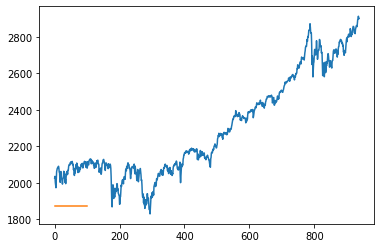

In [415]:
test.reset_index(inplace = True, drop = True)
plt.plot(test['Close'])
plt.plot(prediction)

In [322]:
## test
x1 = np.random.random((len(X_train), 3))

In [187]:
f = np.concatenate([x1, x2])

In [189]:
f.shape

(15, 2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)